# CGAN - Aula Prática


## Configurações

Importando módulos necessários e baixando os datasets.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, CIFAR10
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as K

from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

## Introdução

GANs (Generative Adversarial Networks) são uma arquitetura de rede neural que tem como objetivo gerar novos dados a partir de um conjunto de dados de treinamento. A ideia é que a rede neural seja capaz de aprender a distribuição dos dados de treinamento e, a partir disso, gerar novos dados que sejam semelhantes aos dados de treinamento. Neste notebook, vamos implementar uma GAN para gerar imagens de personagens de anime.


## Dataset

O dataset que vamos utilizar é o [CiFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) que é composto por 60.000 imagens coloridas de 32x32 pixels divididas em 10 classes. As classes são: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship' e 'truck'.

Esse dataset é muito utilizado para treinar modelos de redes neurais convolucionais, mas também pode ser utilizado para treinar GANs.

In [ ]:
cifar10_path = '/pgeoprj2/ciag2024/dados'

In [2]:
# function to plot samples and metadata of a dataset
def plot_dataset(
    dataset,
    n_rows=4,
    n_cols=4,
    figsize=(6, 6),
    denormalize=False,
    label_decoder=lambda x: [x],
):
    print(f'Number of samples: {len(dataset)}')
    print(f'Sample shape: {dataset[0][0].shape}')

    samples = np.random.randint(0, len(dataset), size=(n_rows, n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i in range(n_rows):
        for j in range(n_cols):
            image, label = dataset[samples[i, j]]
            label = label_decoder(label)[0]
            if denormalize:
                image = K.normalize(image, -1, 2)
                image = image.clamp(0, 1)
            image = image.permute(1, 2, 0)
            im = axes[i, j].imshow(image)
            if image.shape[2] == 1:
                im.set_cmap('gray')
            axes[i, j].set_title(label)
            axes[i, j].axis('off')

    plt.show()

In [ ]:
cifar10 = CIFAR10(
    root=cifar10_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

In [14]:
class DatasetLabelMapper(object):
    def __init__(self, dataset):
        self.mapping = {
            i: label for i, label in enumerate(dataset.classes)
        }

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(list(self.mapping.values()))
        # make sure the classes are in order
        self.label_encoder.classes_ = np.array(list(self.mapping.values()))

    def __getitem__(self, label):
        return self.mapping[label]

    def __call__(self, label):
        return self.label_encoder.inverse_transform(
            [label] if isinstance(label, int) else label
        )


label_mapper = DatasetLabelMapper(cifar10)

In [ ]:
plot_dataset(
    cifar10,
    n_cols=6,
    n_rows=6,
    denormalize=True,
    figsize=(8, 9),
    label_decoder=label_mapper,
)

## Modelo

A CGAN (Conditional Generative Adversarial Network) é uma extensão da GAN que permite a geração de imagens condicionadas a uma label. A ideia é que a rede geradora receba uma label como entrada e gere uma imagem correspondente a essa label. A rede discriminadora, por sua vez, recebe a imagem gerada e a label correspondente e tem como objetivo distinguir entre imagens reais e imagens geradas.

A arquitetura da CGAN é semelhante à arquitetura da GAN, mas com a adição de uma label como entrada. A label é concatenada com a entrada da rede geradora e com a entrada da rede discriminadora. Como podemos ver na imagem abaixo:


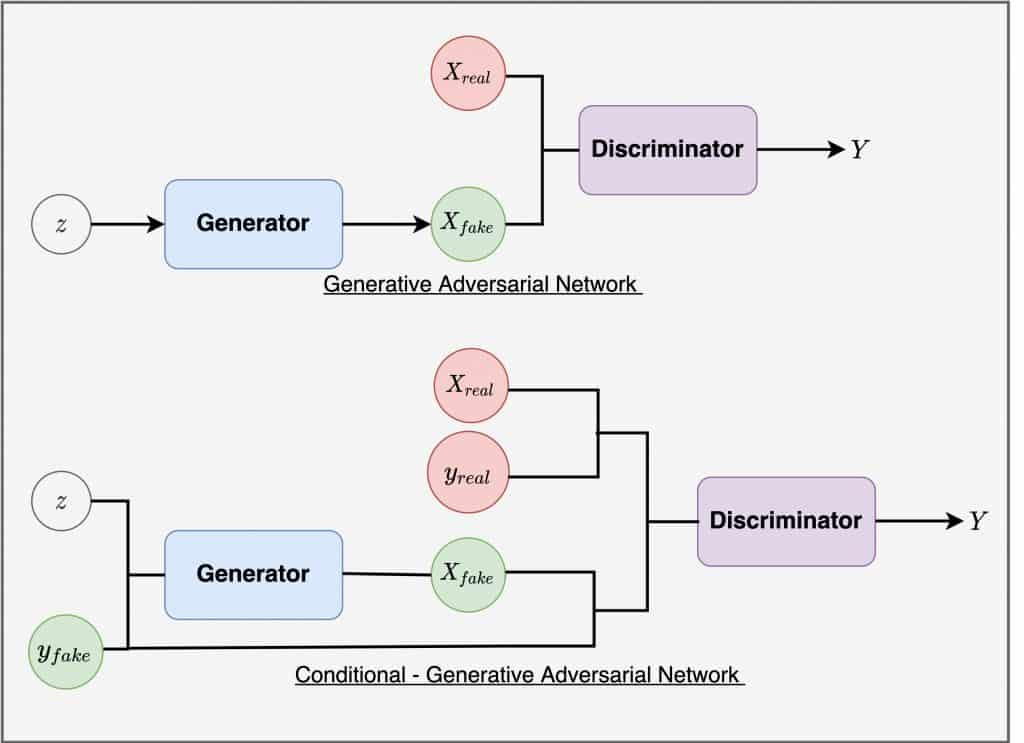


### Gerador

O gerador é uma rede neural que recebe um vetor de valores aleatórios como entrada (a semente da geração) e gera uma imagem como saída. A ideia é que o gerador aprenda a mapear vetores de números aleatórios para imagens que sejam semelhantes às imagens de treinamento. O gerador é treinado para enganar o discriminador, ou seja, para gerar imagens que o discriminador classifica como reais.


In [16]:
def plot_generated_images(
    generator,
    num_images=64,
    num_classes=10,
    latent_dim=128,
    figsize=(6, 6),
    device='cpu',
    denormalize=False,
    label_decoder=lambda x: x,
):

    # generator.eval()

    with torch.no_grad():
        labels = torch.randint(0, num_classes, (num_images,)).to(device)
        noise = torch.randn(num_images, latent_dim, 1, 1).to(device)
        generated_images = generator(labels, noise).cpu()

    labels = label_decoder(labels.cpu())

    generated_images = generated_images.permute(0, 2, 3, 1)
    if denormalize:
        generated_images = K.normalize(generated_images, -1, 2)  # Normalize to (0, 1)

    n_rows = int(math.sqrt(num_images))
    n_cols = int(math.sqrt(num_images))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i in range(n_rows):
        for j in range(n_cols):
            im = axes[i, j].imshow(generated_images[i * n_cols + j])
            if generated_images[i * n_cols + j].shape[-1] == 1:
                im.set_cmap('gray')
            axes[i, j].set_title(labels[i * n_cols + j].item())
            axes[i, j].axis('off')

    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size=128, n_classes=10, output_dim=3):
        super(Generator, self).__init__()

        # latent_size is the size of the input noise vector
        self.latent_size = latent_size
        self.embedding = nn.Sequential(
            nn.Embedding(n_classes, latent_size), 
            nn.Unflatten(1, (latent_size, 1, 1))
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_size*2, 512, kernel_size=4, stride=1, bias=False),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(128, output_dim, kernel_size=3, stride=1, padding=1, bias=False),  # (output_dim, 32, 32)
            nn.Tanh()
        )
    
    def forward(self, y, x=None, batch_size=1):
        if x is None:
            device = next(self.parameters()).device
            x = torch.randn(batch_size, self.latent_size, 1, 1, device=device)
        elif batch_size > 1:
            print('Warning: changing batch_size with x is not supported, the batch size will be the size of x')
        
        y = self.embedding(y)
        
        return self.net(torch.cat([x, y], dim=1))

In [ ]:
generator = Generator(output_dim=3)
generator.to('cuda')
labels = torch.randint(0, 10, (256,), device='cuda')
noise = torch.randn(256, 128, 1, 1, device='cuda')
generator(labels, batch_size=256).shape

In [ ]:
plot_generated_images(
    generator,
    device='cuda',
    num_images=36,
    denormalize=True,
    figsize=(8, 9),
    label_decoder=label_mapper,
)

### Discriminador

O discriminador é uma rede neural que recebe uma imagem como entrada e classifica se a imagem é real (vinda do conjunto de treinamento) ou falsa (gerada). O discriminador é treinado para distinguir entre imagens reais e falsas.


In [33]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, n_classes=10):
        super(Discriminator, self).__init__()

        self.embedding = nn.Sequential(
            nn.Embedding(n_classes, 32*32),
            nn.Unflatten(1, (1, 32, 32))
        )

        self.net = nn.Sequential(
            # +1 for the label channel
            nn.Conv2d(in_channels+1, 64, kernel_size=4, stride=2, padding=1, bias=False), # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, bias=False),  # (1, 1, 1)
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.embedding(y)
        return self.net(torch.cat([x, y], dim=1))

In [ ]:
discriminator = Discriminator()
discriminator.to('cuda')
discriminator(
    torch.randn(256, 3, 32, 32, device='cuda'), torch.randint(0, 10, (256,), device='cuda')
).shape

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset. O modelo será treinado por 32 épocas, com batch size 128 e otimizador Adam.


In [35]:
def train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    num_classes=10,
    epochs=24,
    plot_frequency=None,
    label_mapper=lambda x: x,
):
    generator.to(device)
    discriminator.to(device)

    g_losses_train = []
    d_losses_train = []
    d_accuracies_train = []
    real_scores_train = []
    fake_scores_train = []

    if val_loader is not None:
        g_losses_val = []
        d_losses_val = []
        d_accuracies_val = []
        real_scores_val = []
        fake_scores_val = []

    for epoch in range(epochs):
        generator.train()
        discriminator.train()

        g_loss_train = 0.0
        d_loss_train = 0.0
        d_batch_accuracy = 0.0
        real_score = 0.0
        fake_score = 0.0

        for i, (images, labels) in (
            pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')
        ):
            real_images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            batch_size = real_images.size(0)

            # Train discriminator
            d_optimizer.zero_grad()

            real_outputs = discriminator(real_images, labels)
            real_labels = torch.ones_like(real_outputs, device=device)
            real_loss = criterion(real_outputs, real_labels)

            noise = torch.randn(batch_size, generator.latent_size, 1, 1, device=device)
            fake_images = generator(labels, noise)
            fake_outputs = discriminator(fake_images.detach(), labels)
            fake_labels = torch.zeros_like(fake_outputs, device=device)
            fake_loss = criterion(fake_outputs, fake_labels)

            batch_accuracy = (
                torch.mean(real_outputs >= 0.5, dtype=torch.float32)
                + torch.mean(fake_outputs < 0.5, dtype=torch.float32)
            ) / 2
            d_batch_accuracy += batch_accuracy.item()

            d_loss = real_loss + fake_loss
            d_loss_train += d_loss.item()
            real_score += real_outputs.mean().item()
            fake_score += fake_outputs.mean().item()

            d_loss.backward()
            d_optimizer.step()

            # Train generator
            g_optimizer.zero_grad()

            noise = torch.randn(batch_size, generator.latent_size, 1, 1, device=device)
            fake_images = generator(labels, noise)
            fake_outputs = discriminator(fake_images, labels)

            g_loss = criterion(fake_outputs, real_labels)
            g_loss_train += g_loss.item()

            g_loss.backward()
            g_optimizer.step()

            pbar.set_description(
                f'Epoch {epoch+1}/{epochs} G_Loss: {g_loss_train/((i+1)):.4f} D_Loss: {d_loss_train/(i+1):.4f}'
            )

        g_loss_train /= len(train_loader)
        d_loss_train /= len(train_loader)
        d_accuracy_train = d_batch_accuracy / (len(train_loader))
        real_score /= len(train_loader)
        fake_score /= len(train_loader)

        g_losses_train.append(g_loss_train)
        d_losses_train.append(d_loss_train)
        d_accuracies_train.append(d_accuracy_train)
        real_scores_train.append(real_score)
        fake_scores_train.append(fake_score)

        if val_loader is not None:
            with torch.no_grad():
                generator.eval()
                discriminator.eval()

                g_loss_val = 0.0
                d_loss_val = 0.0
                d_batch_accuracy = 0.0
                real_score = 0.0
                fake_score = 0.0

                for images, labels in val_loader:
                    real_images = images.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    batch_size = real_images.size(0)

                    # Evaluate discriminator

                    real_outputs = discriminator(real_images, labels)
                    real_labels = torch.ones_like(real_outputs, device=device)
                    real_loss = criterion(real_outputs, real_labels)

                    # Generate fake images
                    noise = torch.randn(
                        batch_size, generator.latent_size, 1, 1, device=device
                    )
                    fake_images = generator(labels, noise)

                    fake_outputs = discriminator(fake_images, labels)
                    fake_labels = torch.zeros_like(fake_outputs, device=device)
                    fake_loss = criterion(fake_outputs, fake_labels)

                    batch_accuracy = (
                        torch.mean(real_outputs >= 0.5, dtype=torch.float32)
                        + torch.mean(fake_outputs < 0.5, dtype=torch.float32)
                    ) / 2
                    d_batch_accuracy += batch_accuracy.item()

                    d_loss = real_loss + fake_loss
                    d_loss_val += d_loss.item()
                    real_score += real_outputs.mean().item()
                    fake_score += 1 - fake_outputs.mean().item()

                    # Evaluate generator

                    # reuse fake_images and fake_outputs to save computation
                    g_loss = criterion(fake_outputs, real_labels)

                    g_loss_val += g_loss.item()

                g_loss_val /= len(val_loader)
                d_loss_val /= len(val_loader)
                d_accuracy_val = d_batch_accuracy / len(val_loader)
                real_score /= len(val_loader)
                fake_score /= len(val_loader)

                g_losses_val.append(g_loss_val)
                d_losses_val.append(d_loss_val)
                d_accuracies_val.append(d_accuracy_val)
                real_scores_val.append(real_score)
                fake_scores_val.append(fake_score)
        print(
            f'[Epoch {epoch+1}/{epochs}]\n\tG_Trn_Loss: {g_loss_train:.4f}\tD_Trn_Loss: {d_loss_train:.4f}\tD_Trn_Real: {real_score:.4f}\tD_Trn_Fake: {fake_score:.4f}\tD_Trn_Acc: {d_accuracy_train*100:.2f}%',
            (
                ''
                if val_loader is None
                else f'\n\tG_Val_Loss: {g_loss_val:.4f}\tD_Val_Loss: {d_loss_val:.4f}\tD_Val_Real: {real_score:.4f}\tD_Val_Fake: {fake_score:.4f}\tD_Val_Acc: {d_accuracy_val*100:.2f}%'
            ),
        )

        if plot_frequency is not None and (epoch + 1) % plot_frequency == 0:
            plot_generated_images(
                generator, num_images=25, num_classes=num_classes, device=device, denormalize=True, label_decoder=label_mapper, figsize=(6, 7)
            )

    train_stats = {
        'g_losses': g_losses_train,
        'd_losses': d_losses_train,
        'd_accuracies': d_accuracies_train,
        'real_scores': real_scores_train,
        'fake_scores': fake_scores_train,
    }

    if val_loader is not None:
        val_stats = {
            'g_losses': g_losses_val,
            'd_losses': d_losses_val,
            'd_accuracies': d_accuracies_val,
            'real_scores': real_scores_val,
            'fake_scores': fake_scores_val,
        }

        return train_stats, val_stats

    return train_stats

In [ ]:
train_dataset = CIFAR10(
    root=cifar10_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

val_dataset = CIFAR10(
    root=cifar10_path,
    train=False,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=1, pin_memory=True
)

plot_dataset(train_dataset, n_cols=6, n_rows=6, denormalize=True, figsize=(8, 9), label_decoder=label_mapper)

In [49]:
epochs = 64
latent_dim = 128
num_classes = 10
dataset_dim = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(latent_dim, output_dim=dataset_dim, n_classes=num_classes)
discriminator = Discriminator(in_channels=dataset_dim, n_classes=num_classes)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
criterion = nn.BCELoss()

In [ ]:
train_stats, val_stats = train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    epochs=epochs,
    plot_frequency=4,
    label_mapper=label_mapper,
)

In [ ]:
plot_generated_images(
    generator,
    device=device,
    num_images=36,
    denormalize=True,
    figsize=(8, 9),
    label_decoder=label_mapper,
    num_classes=10,
)

# Exercícios


## Exercício 1

Vamos explorar a função do embedding no gerador. Experimente alterar o tamanho do embedding e o treine com o dataset CIFAR 10. Experimente também remover o embedding do gerador substituindo-o por um OneHotEncoding.

<details>
<summary>Dica:</summary>

Inclua um parâmetro `embedding_size` no construtor do gerador. Utilize o parâmetro para definir o tamanho do embedding.

</details>


### Embedding Variável

In [57]:
class EmbeddingGenerator(nn.Module):
    def __init__(self, latent_size=128, embedding_size=128, n_classes=10, output_dim=3, arch='small'):
        super(EmbeddingGenerator, self).__init__()

        # latent_size is the size of the input noise vector
        self.latent_size = latent_size
        self.embedding_size = embedding_size
        
        # TODO: preencha a camada de embedding
        self.embedding = nn.Sequential(
            ...
        )

        # TODO: preencha a rede neural com a dimensão correta
        self.net = nn.Sequential(
            nn.ConvTranspose2d(..., 512, kernel_size=4, stride=1, bias=False),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.GELU(),
        ) 
        
        # Ainda não se preocupe com essa parte, será utilizada no exercício 2
        if arch == 'large':
            ...  # (output_dim, 64, 64)
        else:
            self.net.append(nn.Conv2d(64, output_dim, kernel_size=3, stride=1, padding=1, bias=False))  # (output_dim, 32, 32)
        
        self.net.append(nn.Tanh())

    def forward(self, y, x=None, batch_size=1):
        if x is None:
            device = next(self.parameters()).device
            x = torch.randn(batch_size, self.latent_size, 1, 1, device=device)
        elif batch_size > 1:
            print('Warning: changing batch_size with x is not supported, the batch size will be the size of x')
        
        y = self.embedding(y)
        
        return self.net(torch.cat([x, y], dim=1))

In [59]:
class EmbeddingDiscriminator(nn.Module):
    def __init__(self, in_channels=3, n_classes=10, embedding_size=128, arch='small'):
        super(EmbeddingDiscriminator, self).__init__()

        # TODO: preencha a camada de embedding
        self.embedding = nn.Sequential(
            ...
        )

        # TODO: preencha a rede neural com a dimensionalidade correta
        self.net = nn.Sequential(
            nn.Conv2d(..., 64, kernel_size=4, stride=2, padding=1, bias=False), # (64, 32, 32) / (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16) / (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8) / (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Ainda não se preocupe com essa parte, será utilizada no exercício 2
        if arch == 'large':
            ... # (1, 1, 1)
        else:
            self.net.append(nn.Conv2d(256, 1, kernel_size=4, bias=False)) # (1, 1, 1)
        
        self.net.append(nn.Flatten())
        self.net.append(nn.Sigmoid())

    def forward(self, x, y):
        y = self.embedding(y)
        return self.net(torch.cat([x, y], dim=1))

In [60]:
# TODO: preencha os hiperparâmetros
# Dica: Teste tamanhos de embedding diferentes para ver o resultado
epochs = ...
latent_dim = ...
num_classes = ...
dataset_dim = ...
embedding_size = ...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = EmbeddingGenerator(latent_dim, n_classes=num_classes, embedding_size=embedding_size, output_dim=dataset_dim, arch='small')
discriminator = EmbeddingDiscriminator(in_channels=dataset_dim, n_classes=num_classes, embedding_size=embedding_size, arch='small')

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
criterion = nn.BCELoss()

In [ ]:
train_stats, val_stats = train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    epochs=epochs,
    plot_frequency=4,
    label_mapper=label_mapper,
)

In [ ]:
plot_generated_images(
    generator,
    device=device,
    num_images=36,
    denormalize=True,
    figsize=(8, 9),
    label_decoder=label_mapper,
)

### Modelo OneHotEncoding

In [64]:
class OneHotGenerator(nn.Module):
    def __init__(self, latent_size=128, n_classes=10, output_dim=3, arch='small'):
        super(OneHotGenerator, self).__init__()

        # latent_size is the size of the input noise vector
        self.latent_size = latent_size
        self.n_classes = n_classes

        # TODO: preencha a camada de embedding
        # Lembre-se que essa camada deve retornar um vetor de n_classesx1x1 para ser concatenado com o vetor de ruído
        self.embedding = nn.Sequential(
            ... # (n_classes, 1, 1)
        )

        # TODO: preencha a rede neural com a dimensão correta
        self.net = nn.Sequential(
            nn.ConvTranspose2d(..., 512, kernel_size=4, stride=1, bias=False),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.GELU(),
        ) 
        
        # Ainda não se preocupe com essa parte, será utilizada no exercício 2
        if arch == 'large':
            ...  # (output_dim, 64, 64)
        else:
            self.net.append(nn.Conv2d(64, output_dim, kernel_size=3, stride=1, padding=1, bias=False))  # (output_dim, 32, 32)
        
        self.net.append(nn.Tanh())
    
    def forward(self, y, x=None, batch_size=1):
        if x is None:
            device = next(self.parameters()).device
            x = torch.randn(batch_size, self.latent_size, 1, 1, device=device)
        elif batch_size > 1:
            print('Warning: changing batch_size with x is not supported, the batch size will be the size of x')

        # TODO: Converta o vetor de classes em um vetor one-hot
        y = ... # (batch_size, n_classes)
        y = self.embedding(y) # (batch_size, n_classes, 1, 1)
        
        return self.net(torch.cat([x, y], dim=1))

In [65]:
class OneHotDiscriminator(nn.Module):
    def __init__(self, in_channels=3, n_classes=10, arch='small'):
        super(OneHotDiscriminator, self).__init__()

        self.n_classes = n_classes

        # TODO: preencha a camada de embedding
        # Lembre-se que essa camada deve retornar um vetor de 1xNxN para ser concatenado com a imagem
        self.embedding = nn.Sequential(
            ... # (1, N, N)
        )

        # TODO: preencha a rede neural com a dimensionalidade correta
        self.net = nn.Sequential(
            nn.Conv2d(..., 64, kernel_size=4, stride=2, padding=1, bias=False), # (64, 32, 32) / (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 16, 16) / (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # (256, 8, 8) / (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Ainda não se preocupe com essa parte, será utilizada no exercício 2
        if arch == 'large':
            ... # (1, 1, 1)
        else:
            self.net.append(nn.Conv2d(256, 1, kernel_size=4, bias=False)) # (1, 1, 1)
        
        self.net.append(nn.Flatten())
        self.net.append(nn.Sigmoid())

    def forward(self, x, y):
        # TODO: Converta o vetor de classes em um vetor one-hot
        y = ... # (batch_size, n_classes)
        y = self.embedding(y) # (batch_size, 1, N, N)

        return self.net(torch.cat([x, y], dim=1))

In [66]:
# TODO: preencha os hiperparâmetros
epochs = ...
latent_dim = ...
num_classes = ...
dataset_dim = ...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = OneHotGenerator(latent_dim, n_classes=num_classes, output_dim=dataset_dim, arch='small')
discriminator = OneHotDiscriminator(in_channels=dataset_dim, n_classes=num_classes, arch='small')

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
criterion = nn.BCELoss()

In [ ]:
train_stats, val_stats = train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    epochs=epochs,
    plot_frequency=4,
    label_mapper=label_mapper,
)

In [ ]:
plot_generated_images(
    generator,
    device=device,
    num_images=36,
    denormalize=True,
    figsize=(8, 9),
    label_decoder=label_mapper,
)

## Exercício 2

Treine uma GAN no dataset [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). O dataset contém imagens de Cachorros de 120 raças diferentes e suas respectivas anotações.

<details>
<summary>Dica:</summary>

Utilize a classe ImageFolder do torchvision.datasets para carregar o dataset. O nome das pastas deve ser o nome da raça do cachorro.

As imagens do dataset possuem tamanhos diferentes, você pode redimensionar as imagens para um tamanho fixo utilizando a classe Resize do torchvision.transforms.

</details>


In [70]:
dogs_path = '/pgeoprj2/ciag2024/dados/GAN/dogs'

### Dataset

O dataset contém imagens de cachorros de 120 raças diferentes. As imagens estão organizadas em pastas, onde o nome da pasta é o nome da raça do cachorro. Vamos importar o dataset e visualizar algumas imagens.

In [71]:
# TODO: Crie um dataset de imagens de cachorros
# Lembre-se de normalizar as imagens para o intervalo [-1, 1]
# O tamanho das imagens deve ser 64x64
dogs_dataset = ImageFolder(
    ...
)

dogs_dataset.classes = [c.split('-')[-1].replace('_', ' ') for c in dogs_dataset.classes]
dogs_mapper = DatasetLabelMapper(dogs_dataset)

In [ ]:
plot_dataset(dogs_dataset, n_cols=6, n_rows=6, denormalize=True, figsize=(12, 12), label_decoder=dogs_mapper)

In [ ]:
# TODO: Crie um DataLoader para o dataset de cachorros
# Separe o dataset em treino e validação, com 80% das imagens para treino
train_dataset, val_dataset = random_split(
    ...
)

# TODO: Crie os dataloaders para o treino e validação
train_loader = DataLoader(
    ...
)
val_loader = DataLoader(
    ...
)

plot_dataset(train_dataset, n_cols=6, n_rows=6, denormalize=True, figsize=(12, 12), label_decoder=dogs_mapper)

### Treinamento

**Importante:** Antes de seguir para o treinamento, retorne ao exercício 1 e altere as classes do gerador e discriminador para gerar e discriminar uma imagem 64x64, respectivamente. Já existe um parâmetro `arch` no construtor que pode ser utilizado para definir a arquitetura da rede.

In [77]:
# TODO: preencha os hiperparâmetros
epochs = ...
latent_dim = ...
num_classes = ...
dataset_dim = ...
embedding_size = ...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = EmbeddingGenerator(latent_dim, output_dim=dataset_dim, embedding_size=embedding_size, n_classes=num_classes, arch='large')
discriminator = EmbeddingDiscriminator(in_channels=dataset_dim, embedding_size=embedding_size, n_classes=num_classes, arch='large')

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
criterion = nn.BCELoss()

In [ ]:
g_stats, d_stats = train(
    generator,
    discriminator,
    train_loader,
    val_loader,
    g_optimizer,
    d_optimizer,
    criterion,
    device,
    num_classes=num_classes,
    epochs=epochs,
    plot_frequency=4,
    label_mapper=dogs_mapper,
)

In [ ]:
plot_generated_images(
    generator, device=device, num_images=36, denormalize=True, figsize=(12, 12), label_decoder=dogs_mapper, num_classes=num_classes
)